## Goal
In previous experiments, we can see `recoverS` in [anchor-word based algorithm](https://drive.google.com/file/d/1R9kdE8u8wPpNQgk40YMawHrAuKJtFfTC/view) step is the bottleneck. Here I want to understand why `recoverS` fails in practice. 

## Notation

* $C_{ij}$ is the co-occurrence probability for words $i, j$: $p(w_1 = i,w_2 = j)$; $\bar{C}_{ij} := p(w_2= j | w_1 = i)$ is row-scaled version of $C_{ij}$; here $C = F A F^T$ where $A = \frac{1}{n} L L ^T$ is also defined below. 
* $S$ is the index set for anchor rows; 
* $F$ and $B$ are both factors/topics;
* $A_{kl} := p(z_1 = k, z_2 = l)$ is the co-occurrence probability for topics $k,l$. 


## Experiment Setup
* I simulate a $(n, p) = (1000, 1200)$ count matrix ($n$ sample size; $p$ dictionary size). 
* There are 3 topics. For each topic there are $20$ top words and top words are 100 times more expressed than other words. 
* For loading I use a logistic-normal (normals are iid).  
* Then I use a document length of $80$ and multinomial model to simulate each document. 
* The underlying model satisfies anchor-word assumption; all the anchor words are also the most frequent words

In [1]:
import os
import sys
import pandas as pd
from scipy import sparse

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
import seaborn as sns
from matplotlib.colors import LogNorm

script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions4 import *
from misc import *
from sinkhorn import * 

np.random.seed(123)

In [2]:
n = 1000
p = 1200 ## make this larger to increase difficulty
n_top = 20 ## number of top words in each topic
k = 3
doc_len = 80

X, Atrue, Ftrue, p0 = smallsim_independent(n = n, p = p, k = k, doc_len = doc_len, n_top = n_top)
w_idx = np.where(X.sum(axis = 0) > 0)[0]
X = X[:,w_idx]

Fit with true C, estimated C, shortened C

In [3]:
%%capture
Ctrue = Ftrue[w_idx,:] @ Atrue @ Ftrue[w_idx,:].T
Strue_fit, Btrue_fit, Atrue_fit, _, _, _, _, _ = factorizeC(Ctrue, K=k, rectifier='no', optimizer='activeSet')

In [4]:
%%capture
Clong, _, _ = X2C(sparse.coo_matrix(X))
Slong_fit, Blong_fit, Along_fit, _, _, _, _, Clong = factorizeC(Clong, K=k, rectifier='AP', optimizer='activeSet')

In [5]:
Clong_bar = Clong / Clong.sum(axis = 1)[:, None]
Ctrue_bar = Ctrue / Ctrue.sum(axis = 1)[:, None]

## Compare geometry between $\bar{C}$ and $\hat{\bar{C}}$

* I project each onto the space of first two (right) singular vectors. Note $C$ is rank 3, but $\bar{C}$ is rank 2, so we are not losing information for $\bar{C}$, and probably not much for $\hat{\bar{C}}$

### Look at selected anchor rows in `Ctrue` 

(row-wise scaled and project to the first two eigenvectors)

In [6]:
# Cbar_proj_true = Cbar_proj(Ctrue)
# weights = Ctrue.sum(axis = 1)
# weights /= weights.max()
# plt.scatter(Cbar_proj_true[:, 0], Cbar_proj_true[:, 1], 
#             s = 3, marker='+',
#             c = weights, cmap="cool")
# plt.show()

true anchor words in true Cbar


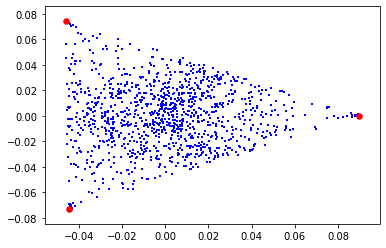

In [7]:
Cbar_proj_true = Cbar_proj(Ctrue)
print("true anchor words in true Cbar")
vis_extremal_pca(Cbar_proj_true, Strue_fit)

recovered anchor words in true Cbar


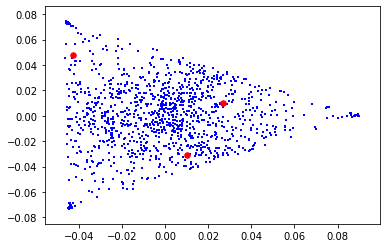

In [8]:
print("recovered anchor words in true Cbar")
vis_extremal_pca(Cbar_proj_true, Slong_fit)

### Look at selected anchor rows in estimated `C`

(row-wise scaled and project to the first two eigenvectors)

In [9]:
# Cbar_proj_long = Cbar_proj(Clong)
# weights = Clong.sum(axis = 1)
# weights /= weights.max()
# plt.scatter(Cbar_proj_long[:, 0], Cbar_proj_long[:, 1], 
#             s = 3, marker='+',
#             c = weights, cmap="cool")
# plt.show()

true anchor words in estimated Cbar


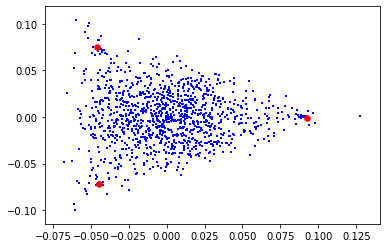

In [10]:
print("true anchor words in estimated Cbar")
Cbar_proj_long = Cbar_proj(Clong)
vis_extremal_pca(Cbar_proj_long, Strue_fit)

recovered anchor words in estimated Cbar


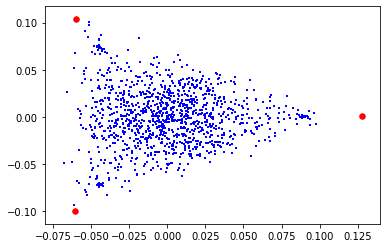

In [11]:
print("recovered anchor words in estimated Cbar")
vis_extremal_pca(Cbar_proj_long, Slong_fit)

### Comment
There are some rarer words that appear more extremal in $\hat{\bar{C}}$ than the true anchor words. `RecoverS` picks up those rarer words, and they are very far from extremal in true $\bar{C}$.  

## Estimation error for $C$ and $\bar{C}$

* Takeaway: Each $C_{ij}$ has very small absolute estimation error; but when converting to $\bar{C}_{ij}$ the error has a multipler of $p$ (still small here; anchor rows have smaller error); then l1 error for each row of $\bar{C}$ has another multipler of $p$ (this seems to be what matters in their theory; also I suspect it's also what matters in the modified Graham-Schimdt procedure in `recoverS`). 

* For $\bar{C}_{ij}$ anchor rows have smaller error. This makes sense as we think how to estimate $p(w_2 = j | w_1 = i)$ directly. 

* Can simplify a bit (disregard dependency) and model $N_{ij} \sim Bin(N(N-1), C_{ij})$ where $N_{ij}$ is the number of occurences for word pair $(i, j)$ and $N$ is the total count of all words in the corpus. When document length is constant, can see our $\hat{C}_{ij}$ is just the MLE for the model above. Therefore each $C_{ij}$ has very small estimation error. Here $N = 80,000$. I did a simulation to check. 

* The paper's theory requires that $|\hat{\bar{C}}^i - \bar{C}^i|_1 \leq \epsilon_C$ and $\epsilon_C$ be small (thm 2.7). But here $\epsilon_C \approx 1$ because of aggregation from $p$ entries. Paper's main theorem gets around this by restricting vocabulary size (merging all low-frequency words). 


In [12]:
## simulation to confirm 
N = X.sum()
print(N)
err = np.abs(
    np.random.binomial(N**2, 1/p**2, size = p**2)/(N**2) -1/p**2)

np.quantile(err, 
            q = [0.5, 0.75, 0.9, 1])

80000.0


array([6.96180556e-09, 1.19618056e-08, 1.71180556e-08, 5.07118056e-08])

In [13]:
np.quantile(np.abs(Clong - Ctrue), 
            q = [0.5, 0.75, 0.9, 1])

array([1.91567654e-08, 3.79557247e-08, 8.22103260e-08, 6.11461797e-05])

In [14]:
np.quantile(np.abs(Clong_bar - Ctrue_bar), 
            q = [0.5, 0.75, 0.9, 1])

array([4.89098833e-05, 8.81846994e-05, 1.45038263e-04, 3.51695739e-02])

In [15]:
np.quantile(np.abs(Clong_bar - Ctrue_bar).sum(axis = 1), 
            q = [0.5, 0.75, 0.9, 1])

array([0.16711699, 0.22157087, 0.27596272, 0.89890373])

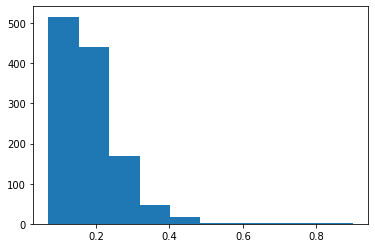

In [16]:
plt.hist(np.abs(Clong_bar - Ctrue_bar).sum(axis = 1))
plt.show()

Only look at anchor rows

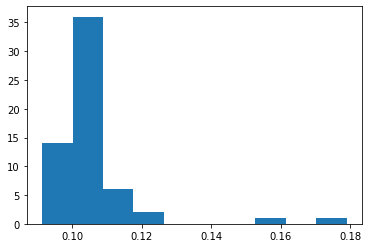

In [17]:
plt.hist(np.abs(Clong_bar - Ctrue_bar).sum(axis = 1)[:60])
plt.show()

Let's visually compare truth and fitted

worst 100th word: p(w = j) = 0.0003; err = 0.2888


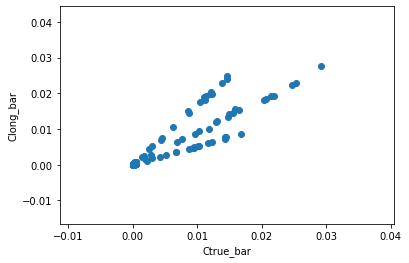

worst 200th word: p(w = j) = 0.0004; err = 0.246


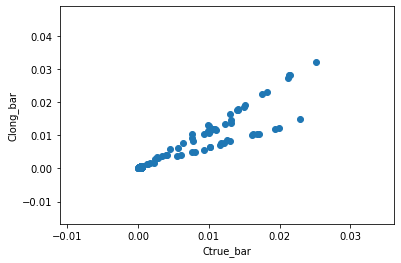

best 300th word: p(w = j) = 0.0004; err = 0.1239


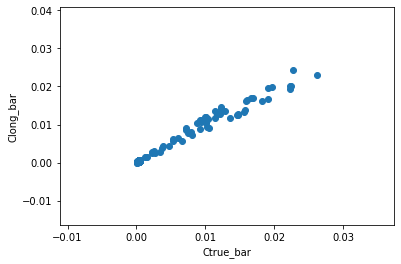

best 201th word: p(w = j) = 0.0003; err = 0.1142


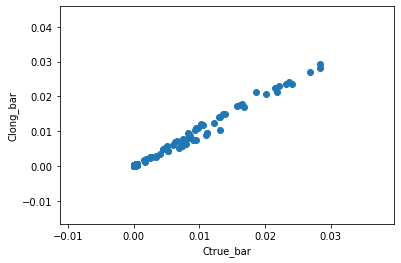

best 100th word: p(w = j) = 0.0205; err = 0.0952


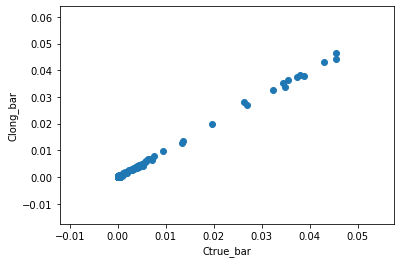

In [58]:
err_l1 = np.abs(Clong_bar - Ctrue_bar).sum(axis = 1)
idx_list = err_l1.argsort()

idx = idx_list[-100]
print("worst 100th word: p(w = j) = {}; err = {}".format(
    Ctrue[idx,:].sum().round(4), err_l1[idx].round(4)))
plt.scatter(Ctrue_bar[idx,:],Clong_bar[idx,:])
plt.xlabel("Ctrue_bar")
plt.ylabel("Clong_bar")
plt.show()


idx = idx_list[-200]
print("worst 200th word: p(w = j) = {}; err = {}".format(
    Ctrue[idx,:].sum().round(4), err_l1[idx].round(4)))
plt.scatter(Ctrue_bar[idx,:],Clong_bar[idx,:])
plt.xlabel("Ctrue_bar")
plt.ylabel("Clong_bar")
plt.show()

idx = idx_list[300]
print("best 300th word: p(w = j) = {}; err = {}".format(
    Ctrue[idx,:].sum().round(4), err_l1[idx].round(4)))
plt.scatter(Ctrue_bar[idx,:],Clong_bar[idx,:])
plt.xlabel("Ctrue_bar")
plt.ylabel("Clong_bar")
plt.show()

idx = idx_list[201]
print("best 201th word: p(w = j) = {}; err = {}".format(
    Ctrue[idx,:].sum().round(4), err_l1[idx].round(4)))
plt.scatter(Ctrue_bar[idx,:],Clong_bar[idx,:])
plt.xlabel("Ctrue_bar")
plt.ylabel("Clong_bar")
plt.show()

idx = idx_list[100]
print("best 100th word: p(w = j) = {}; err = {}".format(
    Ctrue[idx,:].sum().round(4), err_l1[idx].round(4)))
plt.scatter(Ctrue_bar[idx,:],Clong_bar[idx,:])
plt.xlabel("Ctrue_bar")
plt.ylabel("Clong_bar")
plt.show()




In [57]:
1/p ## average p(w = j)

0.0008333333333333334

### Comment
My simulation setup is not very realistic here. There is no word with frequency around average... this poses a big issue for this anchor-word algorithm. 


 ### Possible remedies: 
  * improve estimate of $\bar{C}$ (one way is improving estimate of $C$, by empirical bayes or SVD on bi-whitened data; another way is to directly model $\bar{C}$). I prefer the second way but not sure how.  
        
  * pass on our uncertainty for rows of $\bar{C}$ to `recoverS` algorithm (how to twist the MGS procedure?).  We don't use $p(w = j)$ at all in `recoverS`!!!
  
  * Averaging using neighborhood of "anchor words" to improve robustness?

## Try Sinkhorn

In [19]:
%%capture
Xnorm, r, c = sinkhorn(X, niter = 20)
C_dn = X2C_svd(Xnorm, r = 100)
Sdn_fit, Bdn_fit, Adn_fit, _, _, _, _, C_dn = factorizeC(C_dn, K=k, rectifier='AP', optimizer='activeSet')
Cbar_proj_dn = Cbar_proj(C_dn)

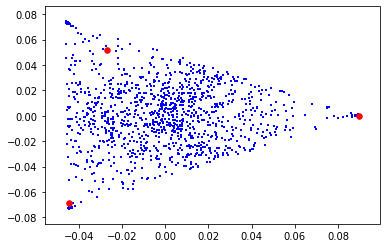

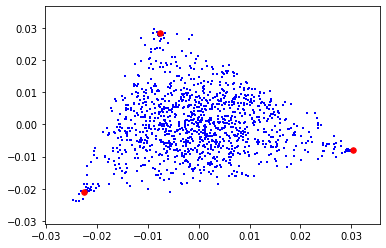

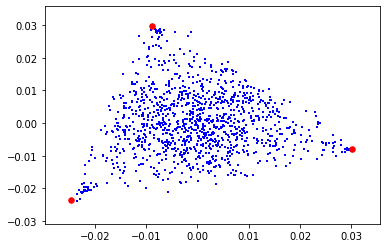

In [20]:
which_dim = [0, 1]
vis_extremal_pca(Cbar_proj_true, Sdn_fit, which_dim)
vis_extremal_pca(Cbar_proj_dn, Strue_fit, which_dim)
vis_extremal_pca(Cbar_proj_dn, Sdn_fit, which_dim)

### comment:

* Sinkhorn + SVD + recification seems to improve `recoverS` a lot by the PCA plot! (Note that `C_dn` and `C_true` mean different things because of sinkhorn procedure; also can be seen by the different shape in PCA plot; neverthless it helps us improve recoverS!!)
* Note that we still need rectification... otherwise recovered `S` are still bad.
* Still one anchor word is pretty bad... so still needs to improve! This is a very easy problem after all.

## Just show easy this problem is

Even NMF with a mispecified model can get anchor words perfectly right. 

In [21]:
%%capture
model = NMF(n_components=k, beta_loss = 'kullback-leibler',
            solver = 'mu', 
            init='random', random_state=0)
W = model.fit_transform(X.T)
H = model.components_

Anmf = (H @ H.T) / n 
Cnmf = W @ Anmf @ W.T
Cnmf_bar = Cnmf/Cnmf.sum(axis=1)[:,None]
Cnmf_bar_pj = Cbar_proj(Cnmf)

Snmf, _, _ = findS(Cnmf_bar, k)

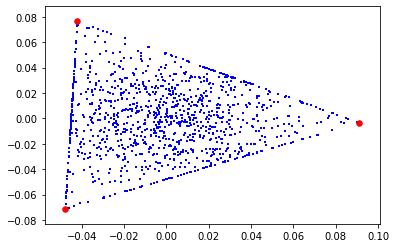

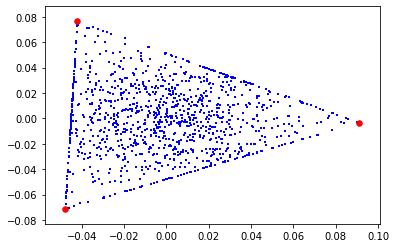

In [22]:
vis_extremal_pca(Cnmf_bar_pj, Snmf, which_dim)
vis_extremal_pca(Cnmf_bar_pj, Strue_fit, which_dim)

In [23]:
%%capture
model2 = NMF(n_components=k, 
            solver = 'mu', 
            init='random', random_state=0)
W = model2.fit_transform(X.T)
H = model2.components_

Anmf = (H @ H.T) / n 
Cnmf = W @ Anmf @ W.T
Cnmf_bar = Cnmf/Cnmf.sum(axis=1)[:,None]
Cnmf_bar_pj = Cbar_proj(Cnmf)
Snmf, _, _ = findS(Cnmf_bar, k)

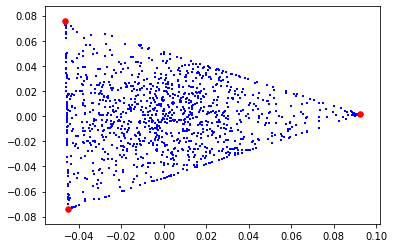

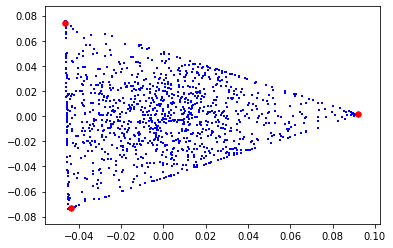

In [24]:
vis_extremal_pca(Cnmf_bar_pj, Snmf, which_dim)
vis_extremal_pca(Cnmf_bar_pj, Strue_fit, which_dim)